In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/BERT/train/台風豪雨福島.xlsx')

#df = df.drop(0)
#df = df.dropna()
#print(df.isnull().sum())

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df[['label','type']])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test[['label','type']])

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [3]:
# 事例数の確認
print('【学習データ】')
print(train['label'].value_counts())
print('【検証データ】')
print(valid['label'].value_counts())
print('【評価データ】')
print(test['label'].value_counts())
print('【データ種類】')
print(train['type'].value_counts())

【学習データ】
1    840
2    840
0    840
Name: label, dtype: int64
【検証データ】
2    105
1    105
0    105
Name: label, dtype: int64
【評価データ】
2    105
1    105
0    105
Name: label, dtype: int64
【データ種類】
t    840
f    840
g    840
Name: type, dtype: int64


In [4]:
!pip install transformers==3.5.1
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
!pip install fugashi
!pip install ipadic
#!pip install adabelief-pytorch

     |████████████████████████████████| 1.3MB 13.3MB/s 
     |████████████████████████████████| 1.1MB 22.6MB/s 
     |████████████████████████████████| 890kB 51.9MB/s 
     |████████████████████████████████| 2.9MB 44.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a396943cfdeae760e3693d6df69449c7fe0c07f81798ed694cdad9057697ee0c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-per

In [5]:
import os
import time

import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertJapaneseTokenizer, BertModel, AutoTokenizer, AutoModel
from torch import optim
from torch import cuda
import torch.nn.functional as F
#from adabelief_pytorch import AdaBelief
from matplotlib import pyplot as plt

SEED_VALUE = 123  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)

In [11]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      padding='max_length',
      truncation=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }


131


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


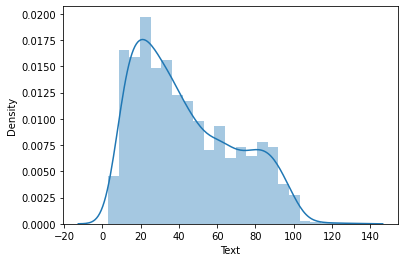

In [12]:
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
#tokenizer = AutoTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# 日本語BERTで扱える文章の長さは512だけど、学習データのツイートの長さは最大でもCLS, SEPトークン入れても131
import seaborn as sns
title_length = df['Text'].map(tokenizer.encode).map(len)
print(max(title_length))

sns.distplot(title_length)

In [13]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['label'])[['label_0', 'label_1', 'label_2']].values
y_valid = pd.get_dummies(valid, columns=['label'])[['label_0', 'label_1', 'label_2']].values
y_test = pd.get_dummies(test, columns=['label'])[['label_0', 'label_1', 'label_2']].values

# Datasetの作成
max_len = 128

dataset_train = CreateDataset(train['Text'], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid['Text'], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test['Text'], y_test, tokenizer, max_len)

# for var in dataset_train[0]:
#   print(f'{var}: {dataset_train[0][var]}')
print(tokenizer.convert_ids_to_tokens(dataset_train[0]['ids']))

['[CLS]', 'め', '##っち', '##ゃ', '風', '強い', '#', '台風', '9', '号', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [14]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, output_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
    #self.bert = AutoModel.from_pretrained("bandainamco-mirai/distilbert-base-japanese")
    self.drop = torch.nn.Dropout(drop_rate)
    self.cls = torch.nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out = self.cls(self.drop(out))
    return out

In [17]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model.forward(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False, num_workers=2, pin_memory=True)

  # 学習
  log_train = []
  log_valid = []

  # 学習の再現性を担保
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device, non_blocking=True)
      mask = data['mask'].to(device, non_blocking=True)
      labels = data['labels'].to(device, non_blocking=True)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model.forward(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [ ]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 3     #ラベルの数に応じて変更する
BATCH_SIZE = 32
NUM_EPOCHS = 2
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
#optimizer = AdaBelief(model.parameters(), lr=5e-4, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = True)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

# モデルのロード
# model_path = F"/content/drive/My Drive/Colab Notebooks/BERT/学習済みモデル/台風豪雨福島.pth"
# log = model.load_state_dict(torch.load(model_path))



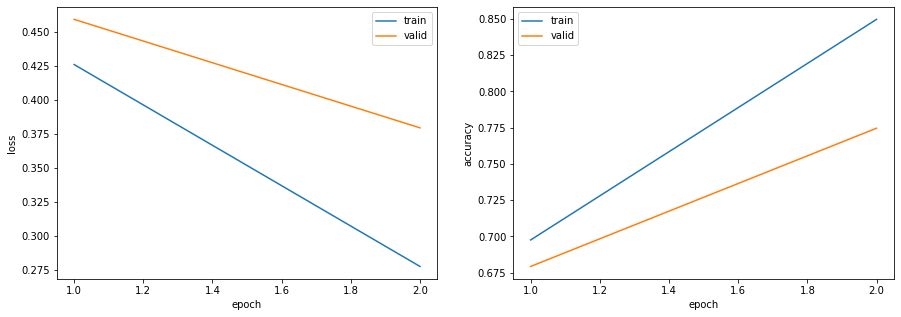

In [32]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)] #学習済みモデルを読み込む際はエラー(log['train'])が定義されていない)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [33]:
# 正解率の算出
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  pred_list = []
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

    labeled = pd.DataFrame()
    labeled['Text'] = test['Text']
    labeled['label'] = test['label']
    labeled['pred'] = pred
    labeled.to_csv('/content/drive/My Drive/Colab Notebooks/BERT/出力結果/台風豪雨福島.csv', index=True, sep=' ')

    y_true = labeled['label']
    y_pred = labeled['pred']
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=['1次情報', '2次情報', '1.5次情報']))

  return correct / total

# print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
# print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
#print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

calculate_accuracy(model, dataset_test, device)

model_save_name = '台風豪雨福島.pth'
path = F"/content/drive/My Drive/Colab Notebooks/BERT/学習済みモデル/{model_save_name}"
torch.save(model.state_dict(), path)

[[83 12 10]
 [ 8 96  1]
 [30  9 66]]
              precision    recall  f1-score   support

        1次情報       0.69      0.79      0.73       105
        2次情報       0.82      0.91      0.86       105
      1.5次情報       0.86      0.63      0.73       105

    accuracy                           0.78       315
   macro avg       0.79      0.78      0.77       315
weighted avg       0.79      0.78      0.77       315

